Visualizing the innards of the three optimization for adaptive behavior on serial neurogym.

In [1]:
#!/usr/bin/env python
# coding: utf-8
# system
import os
import sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')
from pathlib import Path
import json
# tools
import time
import itertools
from collections import defaultdict
# computation
import math
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
# tasks
import gym
import neurogym as ngym
from neurogym.wrappers import ScheduleEnvs
from neurogym.utils.scheduler import RandomSchedule
# models
# from model_dev import RNN_MD
# from model_dev import serial_RNN_MD as RNN_MD
# from utils import get_full_performance
# visualization
import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm, trange
import seaborn as sns
from utils import get_logs_and_files, convert_train_to_test_idx

'files/cognitive_obs/training_log_1_-0.3_100.0__corr_co_reh_tc_mul_gates.npy'

'files/cognitive_obs/training_log_1_-0.3_100.0__corr_co_reh_tc_mul_gates.npy'

In [6]:
# exp_name= 'neurips'
exp_name= 'neurips/policy'
# exp_name= 'neurips/brittle_policy'
# exp_name= 'neurips/td'
# exp_name= 'neurips/bu'
print('current folder: ', os.getcwd())
data_folder = './../files/'+exp_name+'/'
filenames = os.listdir(data_folder)
testing_log_files = [logfile for logfile in filenames if logfile.__contains__('testing_log')]
training_log_files = [logfile for logfile in filenames if logfile.__contains__('training_log')]
config_files = [logfile for logfile in filenames if logfile.__contains__('config')]
# print('config files: ', config_files)
print('testing_logs :', testing_log_files)
print('training_logs :', training_log_files)

current folder:  /home/ahummos/code/multiplicative/analysis
testing_logs : ['testing_log_seed0_paradigm_seq_mul_tasks_14_1.0_0.0_0.4_.npy']
training_logs : ['training_log_seed0_paradigm_seq_mul_tasks_14_1.0_0.0_0.4_.npy']


In [7]:
idx = 0
training_file= data_folder+ training_log_files[idx]
testing_file= data_folder+ testing_log_files[idx]
config_file= data_folder+ config_files[idx]
config= np.load( config_file, allow_pickle=True).item()
training_log = np.load( training_file, allow_pickle=True).item()
testing_log = np.load( testing_file, allow_pickle=True).item()


Bbox(x0=0.125, y0=0.7158695652173913, x1=0.9, y1=0.88)


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


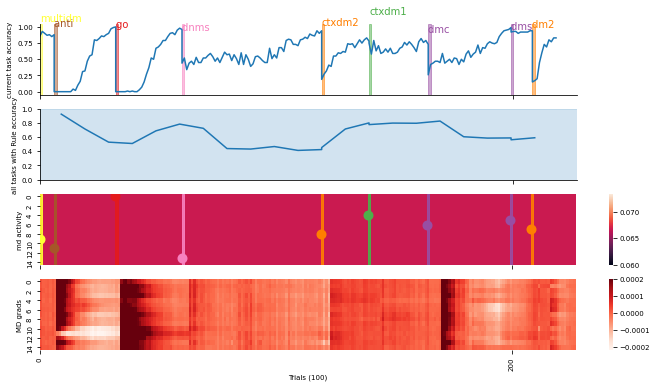

In [9]:
def plot_credit_assignment_inference( config, training_log, testing_log):
    if len(training_log.bu_context_ids) > 0: context_ids =  training_log.bu_context_ids
    elif len(training_log.td_context_ids) > 0: context_ids =  training_log.td_context_ids
    else: 
        # len(training_log.md_context_ids) > 0: 
        policy_context_id = np.ones([1,config.md_size])/config.md_size
        context_ids = [policy_context_id.repeat(config.batch_size, 0)] * training_log.stamps[-1]

    
    mg = np.stack(training_log.md_grads)
    mg = mg.mean(1) #(7957, 15) # average across batch

    x0, x1 = 0, training_log.stamps[-1]
    no_of_values = len(config.tasks)
    norm = mpl.colors.Normalize(vmin=min([0,no_of_values]), vmax=max([0,no_of_values]))
    cmap_obj = mpl.cm.get_cmap('Set1') # tab20b tab20
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)

    switches=  training_log.switch_trialxxbatch[:] 
    # switches=  training_log.switch_trialxxbatch[1:] # earlier on I must have added zero as a switch trial 

    fig, axes = plt.subplots(4,1, figsize=[12,6], sharex = True)

    ax = axes[0]
    print(ax.get_position())
    ax.set_position(matplotlib.transforms.Bbox([[0.125, 0.715], [.747, 0.880]]))

    ax.plot(np.array(training_log.stamps)[x0:x1], np.array(training_log.accuracies)[x0:x1])
    for ri in range(len(switches)-1):
        ax.axvspan(training_log.switch_trialxxbatch[ri], training_log.switch_trialxxbatch[ri]+1, color =cmap.to_rgba(training_log.switch_task_id[ri]) , alpha=0.5)
        id = training_log.switch_task_id[ri]
        task_name = config.human_task_names[id]
        ax.text(training_log.switch_trialxxbatch[ri], 1.0 + np.random.uniform(-0.1, 0.25), task_name, color= cmap.to_rgba(id) , fontsize=10)
    ax.set_ylabel('current task accuracy')
    ax.set_xticks(list(range(0, x1, 200)))
    ax.set_xticklabels([str(i) for i in list(range(0, x1, 200))])
    # ax.set_xlim([x0, x1])
    # for ri in range(len(training_log.switch_trialxxbatch)-1):
    #     ax.axvspan(training_log.switch_trialxxbatch[ri], training_log.switch_trialxxbatch[ri+1], color =cmap.to_rgba(training_log.switch_task_id[ri]) , alpha=0.2)
    ax = axes[1]
    t = 0
    d = training_log.stamps[-1]
    average_acc =[]
    taa = []
    for logi in range(config.num_of_tasks):
        taa.append([test_acc[logi] for test_acc in testing_log.accuracies])
    average_acc.append(np.stack(taa))

    testing_t = convert_train_to_test_idx(training_log, testing_log, t)
    testing_e =convert_train_to_test_idx(training_log, testing_log, t+d)
    ax.plot(testing_log.stamps[testing_t:testing_e], average_acc[0].mean(0)[testing_t:testing_e])
    ax.axvspan(0, d, color='tab:blue', alpha=0.2)
    ax.set_ylim([0,1])
    ax.set_ylabel('all tasks with Rule accuracy')
    # ax.set_title('With task rule input provided')
    # print(ax.get_position())
    ax.set_position(matplotlib.transforms.Bbox([[0.125, 0.519], [.747, 0.683]]))    

    ax = axes[2]
    tdci = np.stack(context_ids)
    mtd = tdci.mean(1) # (7729, 15)
    im = sns.heatmap(mtd.T, ax = ax)
    ax.set_xlim([x0, x1])
    ax.set_ylabel('md activity')
    # ax.colorbar()
    # plt.colorbar(im) #, ax=ax.ravel().tolist())


    ax.set_xlim([x0, x1])

    # ax.set_ylim([0,1])
    for ri in range(len(switches)-1):
        # print(ri)
        ax.scatter(switches[ri], (training_log.switch_task_id[ri]+0.5), color =cmap.to_rgba(training_log.switch_task_id[ri]) ,  linewidth=4, )#alpha=0.2)
        ax.axvspan(training_log.switch_trialxxbatch[ri], training_log.switch_trialxxbatch[ri]+1, color =cmap.to_rgba(training_log.switch_task_id[ri]) , alpha=0.9)

    ax = axes[3]
    ax = sns.heatmap(mg.T, cmap='Reds', ax = ax, vmax=mg.max()/3)
    ax.set_xticks(list(range(0, x1, 200)))
    ax.set_xticklabels([str(i) for i in list(range(0, x1, 200))])
    ax.set_xlim([x0, x1])
    ax.set_ylabel('MD grads')
    ax.set_xlabel('Trials (100)')
    # plt.colorbar(ax)

    # sample_rate = 1
    # hm = sns.heatmap(mg.T, cmap='Reds', ax = ax)
    # # ax.set_yticklabels([str(i) for i in labels])
    # ax.set_ylabel('MD neuron idx', fontsize=8)
    # ax.set_xticks(list(range(0, x1, 200)))
    # ax.set_xticklabels([str(i) for i in list(range(0, x1, 200))])
    # # _=ax.set_xlabel('Trial (1000)', fontsize=8)
    # ax.set_title('MD grads')

    try:
        plt.savefig('./files/'+ config.exp_name+f'/CAI_summary_{config.exp_signature}_bottom_up_optimizing.jpg', dpi=200)
    except:
        # plt.savefig('./../files/'+ config.exp_name+f'/CAI_summary_{config.exp_signature}_bottom_up_optimizing.jpg', dpi=200)
        plt.savefig('./../files/'+ config.exp_name+f'/CAI_summary_{config.exp_signature}_bu_optimizing_many_batches.jpg', dpi=300)
        # plt.savefig('./../files/'+ config.exp_name+f'/CAI_summary_{config.exp_signature}_policy_optimizing.jpg', dpi=200)
plot_credit_assignment_inference(config, training_log, testing_log)

In [23]:
mgg = np.stack(training_log.md_grads)

In [35]:
mgg.shape

(1834, 100, 15)

In [36]:
from utils import stats
stats(mgg)

Mean, 0.00010, var 0.00000, min -0.006, max 0.036, norm 1.014444351196289


'Mean, 0.00010, var 0.00000, min -0.006, max 0.036, norm 1.014444351196289'

In [15]:
training_log.stamps[-1]

9419

In [17]:
training_log.start_optimizing_at

2564

In [18]:
training_log.trials_to_crit

[75,
 23,
 11,
 95,
 13,
 11,
 18,
 60,
 12,
 11,
 14,
 42,
 85,
 11,
 11,
 12,
 13,
 33,
 243,
 23,
 11,
 18,
 43,
 39,
 41,
 89,
 11,
 17,
 39,
 17,
 17,
 51,
 11,
 16,
 13,
 13,
 105,
 11,
 29,
 58,
 12,
 14,
 40,
 41,
 11,
 26,
 11,
 12,
 11,
 39,
 25,
 23,
 12,
 12,
 11,
 32,
 15,
 28,
 30,
 19,
 30,
 12,
 12,
 13,
 19,
 18,
 12,
 12,
 11,
 19,
 12,
 16,
 60,
 12,
 13,
 20,
 12,
 12,
 12,
 11,
 12,
 15,
 89,
 11,
 12,
 20,
 11,
 12,
 13,
 11,
 12,
 12,
 14,
 8,
 7,
 54,
 399,
 25,
 95,
 113,
 293,
 11,
 399,
 8,
 291,
 399,
 41,
 89,
 105,
 212,
 202,
 111,
 399,
 16,
 62,
 399,
 399,
 399,
 399,
 160,
 224,
 9,
 314,
 157,
 6,
 38,
 11,
 96,
 41,
 18,
 399,
 9,
 399]

(0.0, 400.0)

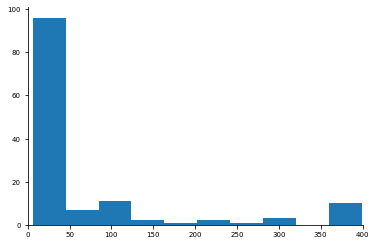

In [9]:
plt.hist(training_log.trials_to_crit) # one_batch
plt.gca().set_xlim([0,400])

(array([16.,  5.,  2.,  2.,  1.,  3.,  0.,  0.,  0.,  1.]),
 array([  7. ,  16.9,  26.8,  36.7,  46.6,  56.5,  66.4,  76.3,  86.2,
         96.1, 106. ]),
 <BarContainer object of 10 artists>)

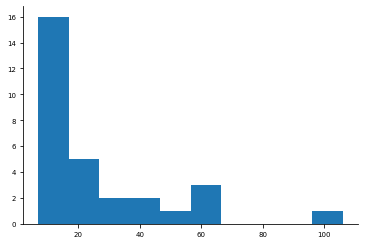

In [74]:
plt.hist(training_log.trials_to_crit)

In [22]:
def plot_accuracies( config, training_log, testing_log):
    no_of_values = len(config.tasks)
    norm = mpl.colors.Normalize(vmin=min([0,no_of_values]), vmax=max([0,no_of_values]))
    cmap_obj = mpl.cm.get_cmap('Set1') # tab20b tab20
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)

    log = testing_log
    training_log.switch_trialxxbatch.append(training_log.stamps[-1])
    num_tasks = len(config.tasks)
    already_seen =[]
    title_label = 'Training tasks sequentially ---> \n    ' + config.exp_name
    max_x = training_log.stamps[-1]
    fig, axes = plt.subplots(num_tasks+4,1, figsize=[9,7])
    for logi in range(num_tasks):
            ax = axes[ logi ] # log i goes to the col direction -->
            ax.set_ylim([-0.1,1.1])
    #         ax.axis('off')
            ax.plot(testing_log.stamps, [test_acc[logi] for test_acc in testing_log.accuracies], linewidth=1)
            ax.plot(testing_log.stamps, np.ones_like(testing_log.stamps)*0.5, ':', color='grey', linewidth=1)
            ax.set_ylabel(config.human_task_names[logi], fontdict={'color': cmap.to_rgba(logi)})
            ax.set_xlim([0, max_x])
            if (logi == num_tasks-1) and config.use_cognitive_observer and config.train_cog_obs_on_recent_trials: # the last subplot, put the preds from cog_obx
                cop = np.stack(training_log.cog_obs_preds).reshape([-1,100,15])
                cop_colors = np.argmax(cop, axis=-1).mean(-1)
                for ri in range(max_x-2):
                    if ri< len(cop_colors):ax.axvspan(ri, ri+1, color =cmap.to_rgba(cop_colors[ri]) , alpha=0.2)
            else:            
                for ri in range(len(training_log.switch_trialxxbatch)-1):
                    ax.axvspan(training_log.switch_trialxxbatch[ri], training_log.switch_trialxxbatch[ri+1], color =cmap.to_rgba(training_log.switch_task_id[ri]) , alpha=0.2)
    for ti, id in enumerate(training_log.switch_task_id):
        if id not in already_seen:
            already_seen.append(id)
            task_name = config.human_task_names[id]
            axes[0].text(training_log.switch_trialxxbatch[ti], 1.3, task_name, color= cmap.to_rgba(id) )

    gs = np.stack(training_log.gradients)

    glabels =  ['inp_w', 'inp_b', 'rnn_w', 'rnn_b', 'out_w', 'out_b']
    ax = axes[num_tasks+0]
    gi =0
    ax.plot(training_log.stamps, gs[:,gi+1], label= glabels[gi])
    gi =2
    ax.plot(training_log.stamps, gs[:,gi+1], label= glabels[gi])
    gi = 4
    ax.plot(training_log.stamps, gs[:,gi+1], label= glabels[gi])
    ax.legend()
    ax.set_xlim([0, max_x])
    ax = axes[num_tasks+1]
    ax.plot(testing_log.stamps,  [np.mean(list(la.values())) for la in testing_log.accuracies] )
    ax.set_ylabel('avg acc')

    ax.plot(testing_log.stamps, np.ones_like(testing_log.stamps)*0.9, ':', color='grey', linewidth=1)
    ax.set_xlim([0, max_x])
    ax.set_ylim([-0.1,1.1])

    ax = axes[num_tasks+2]
    ax.plot(training_log.switch_trialxxbatch[:-1], training_log.trials_to_crit)
    ax.set_ylabel('ttc')
    ax.set_xlim([0, max_x])

    ax = axes[num_tasks+3]
    if len(training_log.stamps) == len(training_log.frustrations):
        ax.plot(training_log.stamps, training_log.frustrations)
    ax.set_ylabel('frust')
    ax.set_xlim([0, max_x])


    final_accuracy_average = np.mean(list(testing_log.accuracies[-1].values()))
    # plt.savefig('./files/'+ config.exp_name+f'/acc_summary_{config.exp_signature}_{training_log.stamps[-1]}_{final_accuracy_average:1.2f}.jpg', dpi=300)


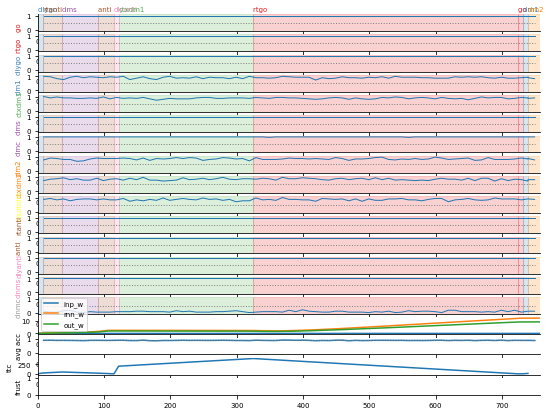

In [23]:
plot_accuracies(config, training_log, testing_log)

ValueError: need at least one array to stack

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


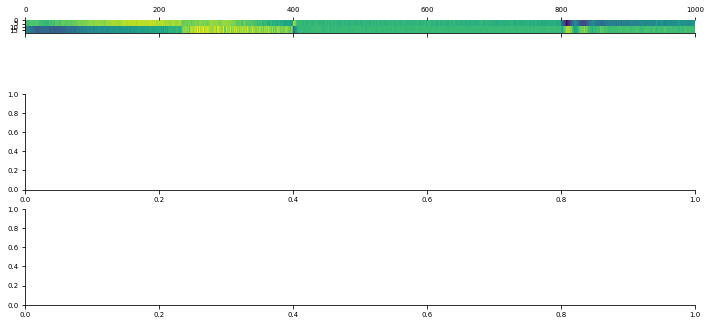

In [ ]:
mg = np.stack(training_log.md_grads)
mg = mg.mean(1) #(7957, 15)
mg_repeated = np.repeat(mg, repeats =10, axis=1)
mg_repeated.shape # xxx, 45

x0, x1 = 0, 1000
fig, axes = plt.subplots(3,1, figsize=[12,6])
ax = axes[0]
ax.matshow(mg_repeated[x0:x1].T)
ax.set_xlim([x0, x1])
# plt.colorbar(ax)

ax = axes[1]
tdci = np.stack(training_log.td_context_ids)
mtd = tdci.mean(1) # (7729, 15)
ax.matshow(np.repeat(mtd[x0:x1], repeats=10, axis=1).T)
ax.set_xlim([x0, x1])

ax = axes[1]
no_of_values = len(config.tasks)-5
norm = mpl.colors.Normalize(vmin=min([0,no_of_values]), vmax=max([0,no_of_values]))
cmap_obj = matplotlib.cm.get_cmap('Set1') # tab20b tab20
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)

switches=  training_log.switch_trialxxbatch + [training_log.stamps[-1]]
ax.set_xlim([x0, x1])

# ax.set_ylim([0,1])
for ri in range(len(switches)-1):
    ax.scatter(switches[ri], training_log.switch_task_id[ri]*10, color =cmap.to_rgba(training_log.switch_task_id[ri]) ,  linewidth=4, )#alpha=0.2)


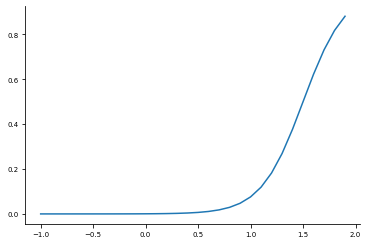

In [ ]:
x = np.arange(-1, 2, 0.1)
func = 1/ (1 + (np.exp(-5*(x-1.5))))
# func = 0.9 * (1-x) + 0.1 * x
plt.plot(x, func)

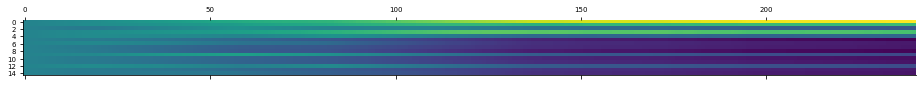

In [ ]:
plt.matshow(nci.squeeze()[::10].T)
plt.savefig('./files/grads.jpg', dpi=600)

In [ ]:
training_log.td_context_ids[0].shape # each one is (100, 15)
tdci = np.stack(training_log.td_context_ids)
mtd = tdci.mean(1) # (7729, 15)

# nci = np.stack(ci)# 2406, 1, 15

In [ ]:
tdci[-100:]

array([[[0.06666667, 0.06666667, 0.06666667, ..., 0.06666667,
         0.06666667, 0.06666667],
        [0.06666667, 0.06666667, 0.06666667, ..., 0.06666667,
         0.06666667, 0.06666667],
        [0.06666667, 0.06666667, 0.06666667, ..., 0.06666667,
         0.06666667, 0.06666667],
        ...,
        [0.06666667, 0.06666667, 0.06666667, ..., 0.06666667,
         0.06666667, 0.06666667],
        [0.06666667, 0.06666667, 0.06666667, ..., 0.06666667,
         0.06666667, 0.06666667],
        [0.06666667, 0.06666667, 0.06666667, ..., 0.06666667,
         0.06666667, 0.06666667]],

       [[0.06666667, 0.06666667, 0.06666667, ..., 0.06666667,
         0.06666667, 0.06666667],
        [0.06666667, 0.06666667, 0.06666667, ..., 0.06666667,
         0.06666667, 0.06666667],
        [0.06666667, 0.06666667, 0.06666667, ..., 0.06666667,
         0.06666667, 0.06666667],
        ...,
        [0.06666667, 0.06666667, 0.06666667, ..., 0.06666667,
         0.06666667, 0.06666667],
        [0.0

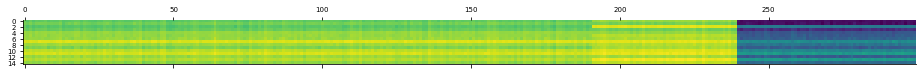

In [ ]:
plt.matshow(mtd[1000:1300].T)

In [ ]:
tasks= [
            'yang19.go-v0',
            'yang19.rtgo-v0',
            'yang19.dlygo-v0',
            'yang19.dm1-v0',
            'yang19.ctxdm1-v0',
            'yang19.dms-v0',
            'yang19.dmc-v0',
            'yang19.dm2-v0',
            'yang19.ctxdm2-v0',
            'yang19.multidm-v0',
            'yang19.rtanti-v0',
            'yang19.anti-v0',
            'yang19.dlyanti-v0',
            'yang19.dnms-v0',
            'yang19.dnmc-v0',
            ]
tasks_id_name = [(i, tasks[i]) for i in range(len(tasks))]
def get_task_id(task_name):
    return((np.argwhere(np.array(tasks) == task_name)).squeeze())
def get_task_name(task_id):
    for ti, tn in tasks_id_name:
        if ti == task_id:
            return (tn)
    return('not found')

# training_log.context_ids[8] # each value is a tuple with (time stamp, [context vector oh])
# training_log.accuracies[0] # each value is the acc average from the current batch
training_log.task_ids[0]


NameError: name 'training_log' is not defined

In [ ]:
cog_tstamps, cog_context_ids = [],[]
for tstamp, context_id in (training_log.context_ids):
    cog_tstamps.append(tstamp)
    cog_context_ids.append(context_id)
cstamps = np.stack(cog_tstamps)
ccontexts = np.stack(cog_context_ids)

NameError: name 'training_log' is not defined

In [ ]:
import imageio
from pathlib import Path
image_path = Path('./../files/to_animate/')
images = sorted(list(image_path.glob('*.jpg')))
image_list = []
for file_name in images:
    image_list.append(imageio.imread(file_name))
imageio.mimwrite('animated_from_images_ccai.gif', image_list, duration=1)


KeyboardInterrupt: 

In [ ]:
no_of_values = 16
norm = mpl.colors.Normalize(vmin=min([0,no_of_values]), vmax=max([0,no_of_values]))
cmap_obj = matplotlib.cm.get_cmap('Set1') # tab20b tab20
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)

Text(640, 15, 'Model discovers tasks')

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


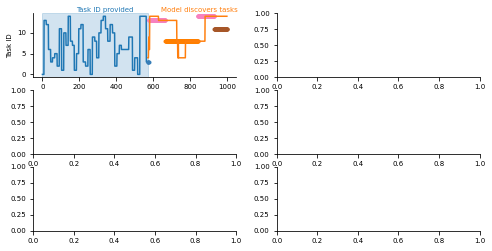

In [ ]:

t = 5250
d = 1000
g = 572
fig, axes = plt.subplots(3,2, figsize=[8,4])

ax = axes[0,0]
ax.plot(training_log.task_ids[t: t+g])

tids = np.stack (training_log.task_ids[t+g:t+d])
ttimes = np.stack(training_log.stamps[t+g:t+d])
# ax.plot(training_log.task_ids[t: t+d])
for i in range(15):
    ax.plot(np.arange(g, g+len(tids))[tids==i], tids[tids==i], '.', color=cmap.to_rgba(i))

pad = np.zeros(572)
d = 1000
ax.plot(np.arange(g, d), np.argmax(ccontexts[:1000-572], axis =-1)[:,0])

ax.set_ylabel('Task ID')
# ax.set_yticks(range(15))
ax.axvspan(0, 572, color='tab:blue', alpha=0.2)
ax.text( 180, 15, 'Task ID provided', color='tab:blue')
ax.text( 640, 15, 'Model discovers tasks', color='tab:orange')


In [ ]:
# tHIS GATHERS all the average accuracies for all saved cognitive observer experiments.
def get_logs_and_files(data_folder, exp_name, file_sig='testing_log'):
    lfiles = os.listdir(data_folder+f'{exp_name}/')
    lfiles = [fn for fn in lfiles if fn.__contains__(file_sig)]
    logs = []
    for fi, fn in enumerate(lfiles):
        try:
            logs.append(np.load(data_folder+f'{exp_name}/' + fn, allow_pickle=True).item())
        except:
            print('some problem with ', fn)
    return(logs, lfiles)

exps = [ 'cognitive_observer', ]
folder_name = './../files/factorized/'
average_acc_dict = {}
for exp_name in exps:
    logs, files_names = get_logs_and_files(folder_name, exp_name, file_sig='testing_log')
    mean_accuracies = []
    totals = []
    average_acc =[]
    for log in logs:
        taa = []
        for logi in range(15):
            taa.append([test_acc[logi] for test_acc in log.accuracies])
        average_acc.append(np.stack(taa))
    average_acc_dict.update({exp_name: (average_acc)})

In [ ]:
def convert_train_to_test_idx(training_log, testing_log, training_idx):
    test_idx = training_log.stamps[training_idx]
    diff_arra = np.abs(np.array(testing_log.stamps) - test_idx)
    test_t_idx = np.argmin(diff_arra)
    return(test_t_idx)

NameError: name 'training_log' is not defined

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


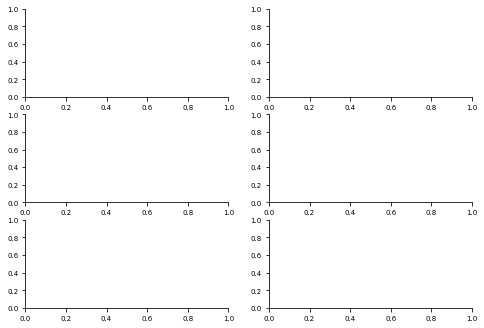

In [ ]:
t = 5250
d = 1000
fig, axes = plt.subplots(3,2, figsize=[8,5.5])
ax = axes[0,0]
ax.plot(training_log.task_ids[t: t+d])
ax.set_ylabel('Task ID')
# ax.set_yticks(range(15))
ax.axvspan(0, 572, color='tab:blue', alpha=0.2)
ax.text( 200, 15, 'Task ID provided', color='tab:blue')
ax.text( 700, 15, 'Model discovers tasks', color='tab:orange')


#model preds
pad = np.zeros(572)
d = 1000
ax.plot(np.arange(g, d), np.argmax(ccontexts[:1000-572], axis =-1)[:,0])
ax.set_xticklabels([''])

ax = axes[1,0]
ax.plot(training_log.accuracies[t: t+d])
ax.axvspan(0, 572, color='tab:blue', alpha=0.2)
ax.set_ylabel('accuracy')
ax.set_xticklabels([''])
ax = axes[2,0]
testing_t = convert_train_to_test_idx(training_log, log, t)
testing_e =convert_train_to_test_idx(training_log, log, t+d)

ax.plot(log.stamps[testing_t:testing_e], average_acc_dict[exp][chosen_log].mean(0)[testing_t:testing_e])
ax.set_ylim([0,1])
ax.set_ylabel('accuracy ALL tasks')


ax = axes[0,1]
t = -1001
d = 1000
tids = np.stack (training_log.task_ids[t:t+d])
ttimes = np.stack(training_log.stamps[t:t+d])
# ax.plot(training_log.task_ids[t: t+d])
for i in range(15):
    ax.plot(ttimes[tids==i], tids[tids==i], '.', color=cmap.to_rgba(i))
ax.set_ylabel('Task ID')
# ax.set_yticks(range(15))
# ax.axvspan(0, 572, color='tab:blue', alpha=0.2)
# ax.text( 200, 15, 'Task ID provided', color='tab:blue')
ax.text( .1, 1.051, 'After some training, task discover speeds up.', transform = ax.transAxes, color='tab:orange')

ax.plot(cstamps[-d:],np.argmax(ccontexts[-d:], axis =-1)[:,0], color='tab:orange')
ax.text( -.13, .080, 'Observer task preds', transform = ax.transAxes, color='tab:orange', rotation=90)

ax = axes[1,1]
ax.plot(ttimes,training_log.accuracies[t: t+d])
ax.set_ylabel('accuracy')

ax = axes[2,1]
testing_t = convert_train_to_test_idx(training_log, log, t)
testing_e =convert_train_to_test_idx(training_log, log, t+d)

ax.plot(log.stamps[testing_t:testing_e], average_acc_dict[exp][chosen_log].mean(0)[testing_t:testing_e])
ax.set_ylim([0,1])
ax.set_ylabel('accuracy ALL tasks')
plt.savefig('./files/cog_observer_inaction_.jpg', dpi=300)


# Get the abandoned model results


/tmp/ipykernel_28539/3910981949.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])


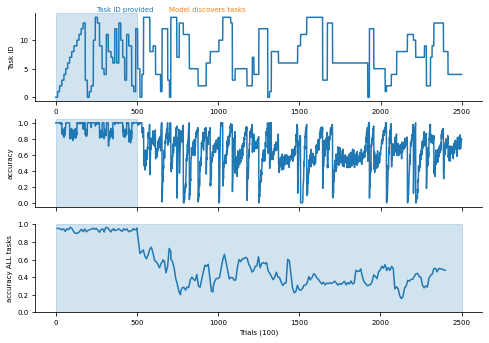

In [ ]:
training_file='./../files/cognitive_obs/training_log_0_-0.3_100.0__corr_noc_reh_tc_mul_gates.npy' #_ordered.npy
training_log = np.load( training_file, allow_pickle=True).item()
config = np.load('./../files/cognitive_obs/config_0_-0.3_100.0__corr_noc_reh_tc_mul_gates.npy', allow_pickle=True).item()
testing_file='./../files/cognitive_obs/testing_log_0_-0.3_100.0__corr_noc_reh_tc_mul_gates.npy'
              #  ./files/cognitive_obs/testing_log_0_-0.3_100.0__corr_noc_reh_tc_mul_gates.npy
log = np.load( testing_file, allow_pickle=True).item()

# tHIS GATHERS all the average accuracies for all saved cognitive observer experiments.
def get_logs_and_files(data_folder, exp_name, file_sig='testing_log'):
    lfiles = os.listdir(data_folder+f'{exp_name}/')
    lfiles = [fn for fn in lfiles if fn.__contains__(file_sig)]
    logs = []
    for fi, fn in enumerate(lfiles):
        try:
            logs.append(np.load(data_folder+f'{exp_name}/' + fn, allow_pickle=True).item())
        except:
            print('some problem with ', fn)
    return(logs, lfiles)

exps = [ 'cognitive_observer', ]
exp= 'cognitive_observer'
average_acc_dict = {}
mean_accuracies = []
average_acc =[]
taa = []
for logi in range(15):
    taa.append([test_acc[logi] for test_acc in log.accuracies])
average_acc.append(np.stack(taa))
average_acc_dict.update({exp_name: (average_acc)})

t = 0
d = min([2500, training_log.stamps[-2]])
fig, axes = plt.subplots(3,1, figsize=[8,5.5])
ax = axes[0]
ax.plot(training_log.task_ids[t: t+d])
ax.set_ylabel('Task ID')
# ax.set_yticks(range(15))
supervised_trials_end = 500
ax.axvspan(0, supervised_trials_end, color='tab:blue', alpha=0.2)
ax.text( int(0.5*supervised_trials_end) , 15, 'Task ID provided', color='tab:blue')
ax.text( 700, 15, 'Model discovers tasks', color='tab:orange')

chosen_log=0
#model preds
pad = np.zeros(supervised_trials_end)
# d = 1000
g =0
# ax.plot(np.arange(g, d), np.argmax(ccontexts[:1000-572], axis =-1)[:])
# ax.set_xticklabels([''])

ax = axes[1]
ax.plot(training_log.accuracies[t: t+d])
ax.axvspan(0, supervised_trials_end, color='tab:blue', alpha=0.2)
ax.set_ylabel('accuracy')
ax.set_xticklabels([''])
ax = axes[2]
testing_t = convert_train_to_test_idx(training_log, log, t)
testing_e =convert_train_to_test_idx(training_log, log, t+d)

ax.plot(log.stamps[testing_t:testing_e], average_acc_dict[exp][chosen_log].mean(0)[testing_t:testing_e])
ax.axvspan(0, d, color='tab:blue', alpha=0.2)
ax.set_ylim([0,1])
ax.set_ylabel('accuracy ALL tasks')
ax.set_xlabel('Trials (100)')
plt.savefig('./files/cog_observer_inaction_.jpg', dpi=300)


Model with ONE neuron in RNN2

/tmp/ipykernel_28539/2448957563.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])


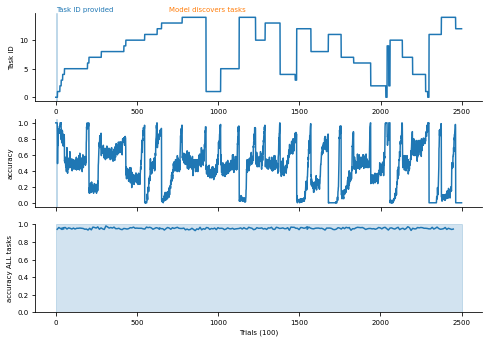

In [ ]:
training_file='./../files/cognitive_obs/training_log_0_-0.3_100.0__corr_noc_reh_tc_mul_gates.npy' #_ordered.npy
training_log = np.load( training_file, allow_pickle=True).item()
config = np.load('./../files/cognitive_obs/config_0_-0.3_100.0__corr_noc_reh_tc_mul_gates.npy', allow_pickle=True).item()
testing_file='./../files/cognitive_obs/testing_log_0_-0.3_100.0__corr_noc_reh_tc_mul_gates.npy'

'files/cognitive_obs/testing_log_singleton0_-0.3_100.0__corr_co_noreh_tc_mul_gates.npy'
training_file='./../files/cognitive_obs/training_log_singleton0_-0.3_100.0__corr_co_noreh_tc_mul_gates.npy' #_ordered.npy
training_log = np.load( training_file, allow_pickle=True).item()
config = np.load('./../files/cognitive_obs/config_singleton0_-0.3_100.0__corr_co_noreh_tc_mul_gates.npy', allow_pickle=True).item()
testing_file='./../files/cognitive_obs/testing_log_singleton0_-0.3_100.0__corr_co_noreh_tc_mul_gates.npy'
              #  ./files/cognitive_obs/testing_log_0_-0.3_100.0__corr_noc_reh_tc_mul_gates.npy
log = np.load( testing_file, allow_pickle=True).item()

# tHIS GATHERS all the average accuracies for all saved cognitive observer experiments.
def get_logs_and_files(data_folder, exp_name, file_sig='testing_log'):
    lfiles = os.listdir(data_folder+f'{exp_name}/')
    lfiles = [fn for fn in lfiles if fn.__contains__(file_sig)]
    logs = []
    for fi, fn in enumerate(lfiles):
        try:
            logs.append(np.load(data_folder+f'{exp_name}/' + fn, allow_pickle=True).item())
        except:
            print('some problem with ', fn)
    return(logs, lfiles)

exps = [ 'cognitive_observer', ]
exp= 'cognitive_observer'
average_acc_dict = {}
mean_accuracies = []
average_acc =[]
taa = []
for logi in range(15):
    taa.append([test_acc[logi] for test_acc in log.accuracies])
average_acc.append(np.stack(taa))
average_acc_dict.update({exp_name: (average_acc)})

t = 0
d = min([2500, training_log.stamps[-2]])
fig, axes = plt.subplots(3,1, figsize=[8,5.5])
ax = axes[0]
ax.plot(training_log.task_ids[t: t+d])
ax.set_ylabel('Task ID')
# ax.set_yticks(range(15))
supervised_trials_end = 10
ax.axvspan(0, supervised_trials_end, color='tab:blue', alpha=0.2)
ax.text( int(0.5*supervised_trials_end) , 15, 'Task ID provided', color='tab:blue')
ax.text( 700, 15, 'Model discovers tasks', color='tab:orange')

chosen_log=0
#model preds
pad = np.zeros(supervised_trials_end)
# d = 1000
g =0
# ax.plot(np.arange(g, d), np.argmax(ccontexts[:1000-572], axis =-1)[:])
# ax.set_xticklabels([''])

ax = axes[1]
ax.plot(training_log.accuracies[t: t+d])
ax.axvspan(0, supervised_trials_end, color='tab:blue', alpha=0.2)
ax.set_ylabel('accuracy')
ax.set_xticklabels([''])
ax = axes[2]
testing_t = convert_train_to_test_idx(training_log, log, t)
testing_e =convert_train_to_test_idx(training_log, log, t+d)

ax.plot(log.stamps[testing_t:testing_e], average_acc_dict[exp][chosen_log].mean(0)[testing_t:testing_e])
ax.axvspan(0, d, color='tab:blue', alpha=0.2)
ax.set_ylim([0,1])
ax.set_ylabel('accuracy ALL tasks')
ax.set_xlabel('Trials (100)')
plt.savefig('./files/cog_observer_inaction_.jpg', dpi=300)


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


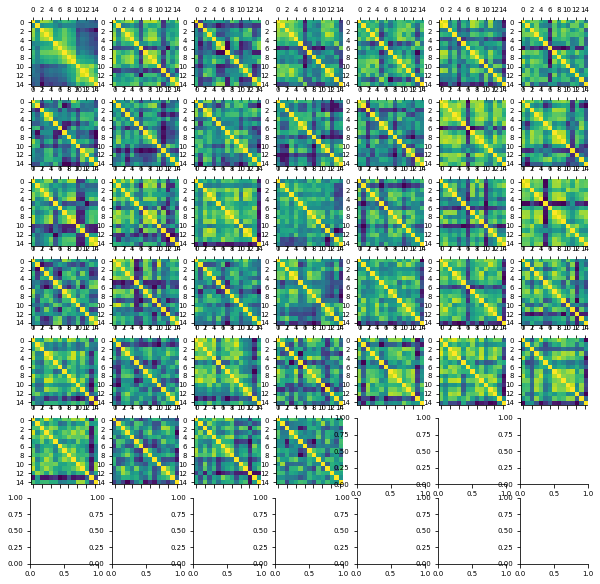

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

data_folder = './../data/'
files = os.listdir(data_folder)
corr_files = [fn for fn in files if fn.__contains__('.npy')]
fig, axes = plt.subplots(7,7, figsize=[10,10])

for ai, cf in enumerate(corr_files):
    corr_mat = np.load(data_folder + cf, allow_pickle=  True).item()['corr_mat']
    axes.flatten()[ai].matshow(corr_mat)


#### Visualizing the MD grads

In [ ]:
exp_name= 'cognitive_obs'
print('current folder: ', os.getcwd())
data_folder = './../files/'+exp_name+'/'
filenames = os.listdir(data_folder)
log_files3 = [logfile for logfile in filenames if logfile.__contains__('testing_log')]
config_files3 = [logfile for logfile in filenames if logfile.__contains__('config')]
training_files = [logfile for logfile in filenames if logfile.__contains__('training_log')]
# print('config files: ', config_files)
print('training_files :', training_files[0])

current folder:  /home/ahummos/code/PFC_MD_Modeling/CL_neurogym/analysis
training_files : training_log_0_-0.3_100.0__corr_co_noreh_tc_mul_gates.npy


In [ ]:
training_log = np.load(data_folder+training_files[0], allow_pickle=True).item()


In [ ]:
mdgrads = np.stack(training_log.md_grads)
print('mdgrads shape: ', mdgrads.shape)

mdgrads shape:  (3685, 100, 15)


[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


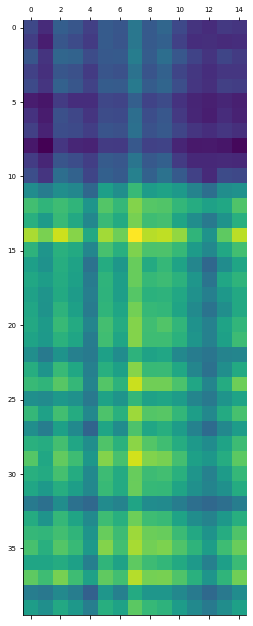

In [ ]:
s,d = 1190,1230
plt.matshow(mdgrads[s:d].mean(1))
print(training_log.task_ids[s:d])

In [ ]:
exp_name= 'order_order_order'
print('current folder: ', os.getcwd())
data_folder = './../files/'+exp_name+'/'
filenames = os.listdir(data_folder)
log_files = [logfile for logfile in filenames if logfile.__contains__('testing_log')]
config_files = [logfile for logfile in filenames if logfile.__contains__('config')]
# print('config files: ', config_files)

log_files1 = [logfile for logfile in log_files if not logfile.__contains__('SecRound')]
log_files2 = [logfile for logfile in log_files if logfile.__contains__('SecRound')]
config_files1 = [logfile for logfile in config_files if not logfile.__contains__('SecRound')]
config_files2 = [logfile for logfile in config_files if logfile.__contains__('SecRound')]
print('testing_logs :', log_files2)

current folder:  /home/ahummos/code/PFC_MD_Modeling/CL_neurogym/analysis
testing_logs : ['testing_log_SecRound_10_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'testing_log_SecRound_11_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'testing_log_SecRound_12_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'testing_log_SecRound_13_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'testing_log_SecRound_14_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'testing_log_SecRound_15_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'testing_log_SecRound_16_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'testing_log_SecRound_17_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'testing_log_SecRound_18_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'testing_log_SecRound_19_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'testing_log_SecRound_3_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'testing_log_SecRound_4_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'testing_log_SecRound_5_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'testing_log_SecRound_6_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'test

In [ ]:
lfiles = log_files1
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())


/tmp/ipykernel_41679/1651177177.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=ax.set_xticklabels( ['', 'random gates','', 'Corr gates', '','No gates'], rotation=0 )
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


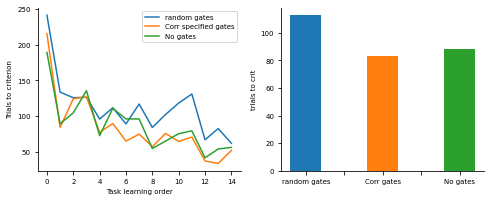

In [ ]:
# Clean up and make into a function
def get_ttc_new_tasks(logs):
    ttc_new_tasks = []

    for log in logs:
        already_seen = []
        new_task_tc = []
        for ti, id in enumerate(log.switch_task_id):
            if id not in already_seen:
                new_task_tc.append(log.switch_trialxxbatch[ti+1]-log.switch_trialxxbatch[ti])
                already_seen.append(id)
                # print('task ID: ', id, '  tc:  ', new_task_tc[-1])

        ttc_new_tasks.append(new_task_tc)
    return(np.stack(ttc_new_tasks))
exp_name= 'order_order_order'
lfiles = log_files1
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())

ttc_new_1st = get_ttc_new_tasks(logs)

lfiles = log_files2
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())

ttc_new_2nd = get_ttc_new_tasks(logs)

exp_name= 'order_order_order_nogates'
lfiles = log_files3
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())

ttc_new_3rd = get_ttc_new_tasks(logs)


fig, axes = plt.subplots(1,2, figsize=([8,3]))
color1= 'tab:blue'
color2= 'tab:orange'
color3= 'tab:green'
m1 = ttc_new_1st.mean(0)
s1 = ttc_new_1st.std(0)
m2 = ttc_new_2nd.mean(0)
s2 = ttc_new_2nd.std(0)
m3 = ttc_new_3rd.mean(0)
s3 = ttc_new_3rd.std(0)
ax =axes[0]
ax.plot(m1, label= 'random gates', color= color1)
# ax.fill_between(range(len(m1)), m1-s1, m1+s1, alpha=0.3, color= color1)
ax.plot(m2, label='Corr specified gates', color= color2)
# ax.fill_between(range(len(m2)), m2-s2, m2+s2, alpha=0.3, color= color2)
ax.plot(m3, label='No gates', color= color3)
ax.legend()
ax.set_xlabel('Task learning order')
ax.set_ylabel('Trials to criterion')

ax =axes[1]

ax.bar(range(5), [m1.mean(),0., m2.mean(), 0.,m3.mean()], color= [ color1, 'b', color2, 'b', color3])
# ax.errorbar(range(5),[m1.mean(),0., m2.mean(), 0.,m3.mean()], [m1.std(),0., m2.std(), 0.,m3.std()])
_=ax.set_xticklabels( ['', 'random gates','', 'Corr gates', '','No gates'], rotation=0 )
ax.set_ylabel('trials to crit')
plt.savefig('trials_to_crit_new_tasks_corr_gates',dpi=300)

/tmp/ipykernel_41679/482370034.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=ax.set_xticklabels( ['', 'rnd gates','', 'Corr gates', '','No gates'], rotation=0 )


Text(0, 0.5, 'trials to crit')

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


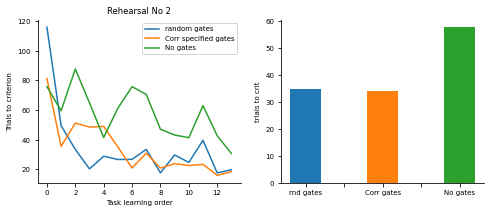

In [ ]:
# Lok at rehearsals

def get_ttc_rehearsals(logs, rehearsal_no):
    rehearsal_data=[]
    for log in logs:
        tstamps = log.switch_trialxxbatch + [log.total_batches]

        counts = np.zeros(15)
        times_seen =[]
        ttcs = []
        for ti, id in enumerate(log.switch_task_id):
            times_seen.append(counts[id])
            ttcs.append(tstamps[ti+1]- tstamps[ti])
            counts[id] +=1
        rehearsal_data.append(np.array(ttcs)[np.array(times_seen)==rehearsal_no])
    return(np.stack(rehearsal_data))
# rd = get_ttc_rehearsals(logs, 1)

rehearsal_no = 2

exp_name= 'order_order_order'
lfiles = log_files1
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())

ttc_reh_1st = get_ttc_rehearsals(logs, rehearsal_no)

lfiles = log_files2
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())

ttc_reh_2nd = get_ttc_rehearsals(logs, rehearsal_no)

exp_name= 'order_order_order_nogates'
lfiles = log_files3
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())
exp_name= 'order_order_order'

ttc_reh_nogates = get_ttc_rehearsals(logs, rehearsal_no)


fig, axes = plt.subplots(1,2, figsize=([8,3]))
color1= 'tab:blue'
color2= 'tab:orange'
color3= 'tab:green'
m1 = ttc_reh_1st.mean(0)
s1 = ttc_reh_1st.std(0)
m2 = ttc_reh_2nd.mean(0)
s2 = ttc_reh_2nd.std(0)
m3 = ttc_reh_nogates.mean(0)
s3 = ttc_reh_nogates.std(0)
ax =axes[0]
ax.plot(m1, label= 'random gates', color= color1)
# ax.fill_between(range(len(m1)), m1-s1, m1+s1, alpha=0.3, color= color1)
ax.plot(m2, label='Corr specified gates', color= color2)
# ax.fill_between(range(len(m2)), m2-s2, m2+s2, alpha=0.3, color= color2)
ax.plot(m3, label='No gates', color= color3)
ax.set_title(f'Rehearsal No {rehearsal_no}')
ax.legend()
ax.set_xlabel('Task learning order')
ax.set_ylabel('Trials to criterion')

ax =axes[1]

ax.bar(range(5), [m1.mean(),0., m2.mean(), 0.,m3.mean()], color= [ color1, 'b', color2, 'b', color3])
# ax.errorbar(range(5),[m1.mean(),0., m2.mean(), 0.,m3.mean()], [m1.std(),0., m2.std(), 0.,m3.std()])
_=ax.set_xticklabels( ['', 'rnd gates','', 'Corr gates', '','No gates'], rotation=0 )
ax.set_ylabel('trials to crit')

# plt.savefig(f'trials_to_crit_{rehearsal_no}th_rehearsal_tasks_corr_gates.jpg',dpi=300)

No handles with labels found to put in legend.


Text(0, 0.5, 'Trials to criterion')

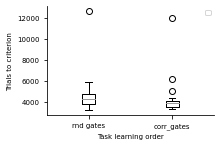

In [ ]:
exp_name= 'order_order_order'
lfiles = log_files1
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())

random_gates_totals = [log.total_batches for log in logs]
random_gates_totals_m = np.mean(random_gates_totals)

lfiles = log_files2
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())

corr_gates_totals = [log.total_batches for log in logs]

fig, ax = plt.subplots(1,1, figsize=([3,2]))

color1= 'tab:blue'
color2= 'tab:orange'
# ax.boxplot(['rnd gates', 'corr_gates'], [np.mean(r) for r in [random_gates_totals, corr_gates_totals]], color= [color1, color2])
# ax.errorbar(range(5),[m1.mean(),0., m2.mean(), 0.,m3.mean()], [m1.std(),0., m2.std(), 0.,m3.std()])
ax.boxplot([random_gates_totals, corr_gates_totals], labels=['rnd gates', 'corr_gates'])
ax.legend()
ax.set_xlabel('Task learning order')
ax.set_ylabel('Trials to criterion')


Text(0, 0.5, 'Trials to criterion')

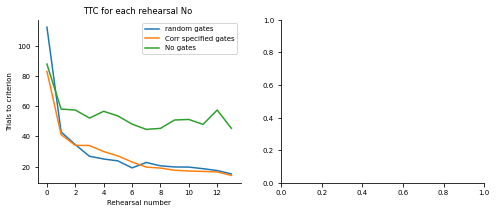

In [ ]:
# get all rehearsal orders

exp_name= 'order_order_order'
lfiles = log_files1
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())

rehearsal_total = 14
ttc_reh_1st = [get_ttc_rehearsals(logs, rehearsal_no) for rehearsal_no in range(rehearsal_total)]


lfiles = log_files2
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())

ttc_reh_2nd = [get_ttc_rehearsals(logs, rehearsal_no) for rehearsal_no in range(rehearsal_total)]

exp_name= 'order_order_order_nogates'
lfiles = log_files3
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())
exp_name= 'order_order_order'

ttc_reh_nogates = [get_ttc_rehearsals(logs, rehearsal_no) for rehearsal_no in range(rehearsal_total)]


fig, axes = plt.subplots(1,2, figsize=([8,3]))
color1= 'tab:blue'
color2= 'tab:orange'
color3= 'tab:green'


# m1 = ttc_reh_1st.mean(0)
# s1 = ttc_reh_1st.std(0)
# m2 = ttc_reh_2nd.mean(0)
# s2 = ttc_reh_2nd.std(0)
# m3 = ttc_reh_nogates.mean(0)
# s3 = ttc_reh_nogates.std(0)
ax =axes[0]
# ttc_reh has a list of rehearsal no, but split by learning order. I should just avg all 
# data, so basically ttc for this rehearsal no no matter where in the learning order,
# what is the shape inside each of them? [no of exps, order number, ] 
ax.plot([dp.mean() for dp in ttc_reh_1st], label= 'random gates', color= color1)
# ax.fill_between(range(len(m1)), m1-s1, m1+s1, alpha=0.3, color= color1)
ax.plot([dp.mean() for dp in ttc_reh_2nd], label='Corr specified gates', color= color2)
# ax.fill_between(range(len(m2)), m2-s2, m2+s2, alpha=0.3, color= color2)
ax.plot([dp.mean() for dp in ttc_reh_nogates], label='No gates', color= color3)
ax.set_title('TTC for each rehearsal No ')
ax.legend()
ax.set_xlabel('Rehearsal number')
ax.set_ylabel('Trials to criterion')


# Factorized experiments

In [ ]:
experiments = ['same_net', 'train_to_criterion', 'rehearsal', 'random_gates',  'correlated_gates', 'cognitive_observer', ]
folder_name = './../files/factorized/'


In [ ]:
def get_logs_and_files(data_folder, exp_name):
    lfiles = os.listdir(data_folder+f'{exp_name}/')
    lfiles = [fn for fn in lfiles if fn.__contains__('testing_log')]
    logs = []
    for fi, fn in enumerate(lfiles):
        try:
            logs.append(np.load(data_folder+f'{exp_name}/' + fn, allow_pickle=True).item())
        except:
            print('some problem with ', fn)
    return(logs)

In [ ]:
def get_ttc_rehearsals(logs, rehearsal_no):
    rehearsal_data=[]
    for log in logs:
        tstamps = log.switch_trialxxbatch + [log.total_batches]

        counts = np.zeros(15)
        times_seen =[]
        ttcs = []
        for ti, id in enumerate(log.switch_task_id):
            times_seen.append(counts[id])
            ttcs.append(tstamps[ti+1]- tstamps[ti])
            counts[id] +=1
        rehearsal_data.append(np.array(ttcs)[np.array(times_seen)==rehearsal_no])
    return(np.stack(rehearsal_data))


In [ ]:
logs = get_logs_and_files(folder_name, 'rehearsal')
def new_get_rehearsals(logs, rehreasal_no=1):

    print('swtch \ttid \t rehNo \t ttc \t order')
    rehearsal_ttcs = []
    for log in logs:
        times_seen = []
        order_learned = []
        ttc = []
        np_task_id = np.array(log.switch_task_id)
        np_stamps = log.switch_trialxxbatch + [log.total_batches]
        for i in range(len(log.switch_trialxxbatch)):
            times_seen.append( np.sum( np_task_id[:i]== log.switch_task_id[i]))
            order_learned.append(np.sum( np.array(times_seen)== times_seen[-1]))
            ttc.append(np_stamps[i+1]- np_stamps[i])
        rehearsal_ttcs.append(np.array(ttc)[np.array(times_seen)==rehearsal_no])
    for i in (range(12)):
        print(log.switch_trialxxbatch[i], '\t', log.switch_task_id[i], '\t', times_seen[i], '\t', ttc[i], '\t', order_learned[i])
    
    return( np.stack(rehearsal_ttcs) )

rt = new_get_rehearsals(logs, 1)

swtch 	tid 	 rehNo 	 ttc 	 order
0 	 11 	 0 	 61 	 1
61 	 3 	 0 	 68 	 2
129 	 11 	 1 	 27 	 1
156 	 3 	 1 	 114 	 2
270 	 8 	 0 	 81 	 3
351 	 11 	 2 	 38 	 1
389 	 3 	 2 	 69 	 2
458 	 8 	 1 	 59 	 3
517 	 0 	 0 	 12 	 4
529 	 11 	 3 	 48 	 1
577 	 3 	 3 	 92 	 2
669 	 8 	 2 	 64 	 3


In [ ]:
rt.shape # no_of_seeds, no_of tasks with 1 rehearsal  19, 14


(19, 14)

In [ ]:
logs = get_logs_and_files(folder_name, 'rehearsal')
log = logs[0]
print('swtch \ttid \t rehNo \t ttc \t order')
times_seen = []
order_learned = []
ttc = []
np_task_id = np.array(log.switch_task_id)
np_stamps = log.switch_trialxxbatch + [log.total_batches]
for i in range(len(log.switch_trialxxbatch)):
    times_seen.append( np.sum( np_task_id[:i]== log.switch_task_id[i]))
    order_learned.append(np.sum( np.array(times_seen)== times_seen[-1]))
    ttc.append(np_stamps[i+1]- np_stamps[i])

for i in (range(12)):
    print(log.switch_trialxxbatch[i], '\t', log.switch_task_id[i], '\t', times_seen[i], '\t', ttc[i], '\t', order_learned[i])

swtch 	tid 	 rehNo 	 ttc 	 order
0 	 0 	 0 	 58 	 1
58 	 1 	 0 	 14 	 2
72 	 0 	 1 	 11 	 1
83 	 1 	 1 	 11 	 2
94 	 2 	 0 	 68 	 3
162 	 0 	 2 	 12 	 1
174 	 1 	 2 	 11 	 2
185 	 2 	 1 	 67 	 3
252 	 3 	 0 	 70 	 4
322 	 0 	 3 	 12 	 1
334 	 1 	 3 	 11 	 2
345 	 2 	 2 	 66 	 3


In [ ]:
ttc_1st_rehearsal_by_learning_order = np.array(ttc)[np.array(times_seen)==2]
print('ttc:', ttc_1st_rehearsal_by_learning_order)
ttc_1st_rehearsal_by_learning_order = np.array(order_learned)[np.array(times_seen)==2]
print('ord:', ttc_1st_rehearsal_by_learning_order)

ttc: [12 11 66 19 39 27 12 30 49 40 21 18 21 78]
ord: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


train_to_criterion
swtch 	tid 	 rehNo 	 ttc 	 order
0 	 11 	 0 	 53 	 1
53 	 3 	 0 	 70 	 2
123 	 8 	 0 	 66 	 3
189 	 0 	 0 	 12 	 4
201 	 7 	 0 	 37 	 5
238 	 12 	 0 	 207 	 6
445 	 1 	 0 	 23 	 7
468 	 13 	 0 	 217 	 8
685 	 6 	 0 	 182 	 9
867 	 14 	 0 	 356 	 10
1223 	 5 	 0 	 154 	 11
1377 	 10 	 0 	 23 	 12
rehearsal
swtch 	tid 	 rehNo 	 ttc 	 order
0 	 11 	 0 	 61 	 1
61 	 3 	 0 	 68 	 2
129 	 11 	 1 	 27 	 1
156 	 3 	 1 	 114 	 2
270 	 8 	 0 	 81 	 3
351 	 11 	 2 	 38 	 1
389 	 3 	 2 	 69 	 2
458 	 8 	 1 	 59 	 3
517 	 0 	 0 	 12 	 4
529 	 11 	 3 	 48 	 1
577 	 3 	 3 	 92 	 2
669 	 8 	 2 	 64 	 3
random_gates
swtch 	tid 	 rehNo 	 ttc 	 order
0 	 9 	 0 	 291 	 1
291 	 7 	 0 	 68 	 2
359 	 9 	 1 	 35 	 1
394 	 7 	 1 	 20 	 2
414 	 2 	 0 	 37 	 3
451 	 9 	 2 	 58 	 1
509 	 7 	 2 	 20 	 2
529 	 2 	 1 	 14 	 3
543 	 6 	 0 	 195 	 4
738 	 9 	 3 	 39 	 1
777 	 7 	 3 	 24 	 2
801 	 2 	 2 	 38 	 3


No handles with labels found to put in legend.


correlated_gates
swtch 	tid 	 rehNo 	 ttc 	 order
0 	 9 	 0 	 188 	 1
188 	 7 	 0 	 28 	 2
216 	 9 	 1 	 74 	 1
290 	 7 	 1 	 14 	 2
304 	 2 	 0 	 20 	 3
324 	 9 	 2 	 24 	 1
348 	 7 	 2 	 20 	 2
368 	 2 	 1 	 25 	 3
393 	 6 	 0 	 193 	 4
586 	 9 	 3 	 79 	 1
665 	 7 	 3 	 19 	 2
684 	 2 	 2 	 42 	 3


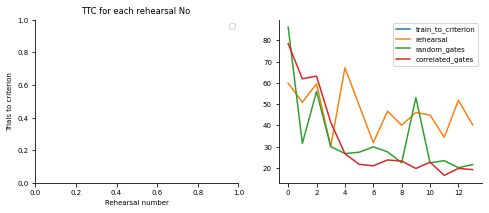

In [ ]:
# get all rehearsal orders


rehearsal_total = 14
rehearsal_no = 2
exps_to_plot = [  'rehearsal', 'random_gates',  'correlated_gates',]# 'cognitive_observer', ]

fig, axes = plt.subplots(1,2, figsize=([8,3]))
for expn in exps_to_plot:

    logs = get_logs_and_files(folder_name, expn)
    print(expn)
    rehearsal_ttc = new_get_rehearsals(logs, rehearsal_no)
    ax = axes[1]
    ax.plot(rehearsal_ttc.mean(0), label=expn)
    ax =axes[0]
    # ax.plot([dp.mean() for dp in rehearsal_ttc], label= expn,)
    

color1= 'tab:blue'
color2= 'tab:orange'
color3= 'tab:green'

ax = axes[1]
ax.legend()
ax = axes[0]
ax.set_title('TTC for each rehearsal No ')
ax.legend()
ax.set_xlabel('Rehearsal number')
ax.set_ylabel('Trials to criterion')
plt.savefig(f'{rehearsal_no}st_rehearsal_new_data.jpg', dpi=300)


train_to_criterion


/tmp/ipykernel_18002/3002299939.py:18: RuntimeWarning: Mean of empty slice.
  ax.plot([dp.mean() for dp in rehearsal_ttc], label= expn,)
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


rehearsal
random_gates
correlated_gates


Text(0, 0.5, 'Trials to criterion')

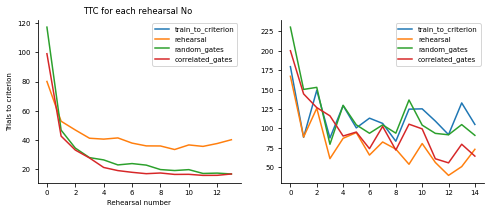

In [ ]:
# get all rehearsal orders


rehearsal_total = 14

exps_to_plot = [ 'train_to_criterion', 'rehearsal', 'random_gates',  'correlated_gates',]# 'cognitive_observer', ]

fig, axes = plt.subplots(1,2, figsize=([8,3]))
for expn in exps_to_plot:

    logs = get_logs_and_files(folder_name, expn)
    print(expn)
    rehearsal_ttc = [get_ttc_rehearsals(logs, rehearsal_no) for rehearsal_no in range(rehearsal_total)]

    ax = axes[1]
    ax.plot(rehearsal_ttc[0].mean(0), label=expn)
    ax =axes[0]
    ax.plot([dp.mean() for dp in rehearsal_ttc], label= expn,)
    

color1= 'tab:blue'
color2= 'tab:orange'
color3= 'tab:green'

ax = axes[1]
ax.legend()
ax = axes[0]
ax.set_title('TTC for each rehearsal No ')
ax.legend()
ax.set_xlabel('Rehearsal number')
ax.set_ylabel('Trials to criterion')


In [ ]:
# Compile ALL rehearsals

def get_rehearsal_stamps(log_files, exp_name, rehearsal_no=None):
    ''' if rehearsal_no is None do not filter and return all rehearsals'''
    rehearsal_data=[]
    data = []
    logs = []
    for fn in log_files:
        logs.append(np.load(fn, allow_pickle=True).item())
    for log in logs:
        tstamps = log.switch_trialxxbatch + [log.total_batches]

        counts = np.zeros(15)
        times_seen =[]
        ttcs = []
        for ti, id in enumerate(log.switch_task_id):
            times_seen.append(counts[id])
            ttcs.append(tstamps[ti+1]- tstamps[ti])
            counts[id] +=1
        rehearsal_data.append(np.array(ttcs)[np.array(times_seen)==rehearsal_no])
        stamp_tid_no_rehearsals = np.array([log.switch_trialxxbatch,log.switch_task_id , ttcs, times_seen])
        data.append(stamp_tid_no_rehearsals)
    return(np.stack(data))

exp_name= 'order_order_order'
lfiles = log_files1.copy()
for fi, fn in enumerate(lfiles):
    lfiles[fi] = f'./../files/{exp_name}/' + fn 
stamp_tid_no_rehearsals = get_rehearsal_stamps(lfiles, 'order_order_order', None)

    


In [ ]:
print('shape: ', stamp_tid_no_rehearsals.shape) #(17, 4, 134)


shape:  (17, 4, 134)


In [ ]:
exp_name= 'order_order_order'
lfiles = log_files1
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())


In [ ]:
log_id = 0
print('no of time stamps: ', len(logs[log_id].stamps))
stamp_tid_no_rehearsals[log_id][0]


no of time stamps:  497


array([   0.,  172.,  338.,  366.,  470.,  507.,  529.,  547.,  559.,
        784.,  834.,  889.,  912., 1059., 1191., 1211., 1240., 1252.,
       1278., 1352., 1568., 1597., 1643., 1657., 1751., 1790., 1849.,
       1917., 1934., 1960., 1972., 1985., 2006., 2037., 2062., 2222.,
       2256., 2298., 2312., 2345., 2378., 2397., 2428., 2464., 2482.,
       2501., 2518., 2529., 2543., 2561., 2574., 2605., 2618., 2630.,
       2744., 2763., 2785., 2797., 2809., 2827., 2841., 2862., 2875.,
       2886., 2922., 3089., 3137., 3195., 3207., 3266., 3290., 3314.,
       3344., 3442., 3454., 3491., 3519., 3725., 3742., 3756., 3768.,
       3782., 3800., 3823., 3844., 3875., 3887., 3928., 3942., 4018.,
       4044., 4065., 4079., 4091., 4104., 4118., 4140., 4156., 4177.,
       4189., 4211., 4224., 4269., 4285., 4308., 4327., 4350., 4362.,
       4376., 4389., 4402., 4417., 4429., 4441., 4468., 4480., 4510.,
       4522., 4533., 4579., 4596., 4608., 4619., 4637., 4649., 4667.,
       4678., 4691.,

In [ ]:
#Get time stamps of new trials:
print('time stamps of new tasks: \n', stamp_tid_no_rehearsals[log_id][0][stamp_tid_no_rehearsals[log_id][3]==0])
print('No of trials for new tasks: \n', stamp_tid_no_rehearsals[log_id][2][stamp_tid_no_rehearsals[log_id][3]==0])
print('time stamps in testing log: ', logs[log_id].stamps)

time stamps of new tasks: 
 [   0.  172.  470.  559. 1059. 1352. 1849. 2062. 2464. 2630. 2922. 3519.
 4018. 4285. 4533.]
No of trials for new tasks: 
 [172. 166.  37. 225. 132. 216.  68. 160.  18. 114. 167. 206.  26.  23.
  46.]
time stamps in testing log:  [9, 19, 29, 39, 49, 59, 69, 79, 89, 99, 109, 119, 129, 139, 149, 159, 169, 179, 189, 199, 209, 219, 229, 239, 249, 259, 269, 279, 289, 299, 309, 319, 329, 339, 349, 359, 369, 379, 389, 399, 409, 419, 429, 439, 449, 459, 469, 479, 489, 499, 509, 519, 529, 529, 539, 549, 559, 559, 569, 579, 589, 599, 609, 619, 629, 639, 649, 659, 669, 679, 689, 699, 709, 719, 729, 739, 749, 759, 769, 779, 789, 799, 809, 819, 829, 839, 849, 859, 869, 879, 889, 889, 899, 909, 919, 929, 939, 949, 959, 969, 979, 989, 999, 1009, 1019, 1029, 1039, 1049, 1059, 1059, 1069, 1079, 1089, 1099, 1109, 1119, 1129, 1139, 1149, 1159, 1169, 1179, 1189, 1199, 1209, 1219, 1229, 1239, 1249, 1259, 1269, 1279, 1289, 1299, 1309, 1319, 1329, 1339, 1349, 1359, 1369, 1379, 138

Now the issue is how to get performance data for these when testing is at 0.1 Hz?.... 

In [ ]:
new_task_s = 172
new_task_s_test_u = np.argmax((np.array(logs[log_id].stamps) > new_task_s).astype(float)) # gives the index location of the next higher time stamp. 
new_task_s_test_l = new_task_s_test_u -1
new_task_e = new_task_s + 

17

Text(0.5, 1.0, '5th rehearsal')

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


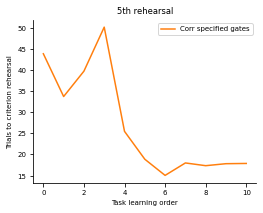

In [ ]:

exp_name= 'order_order_order'
lfiles = log_files1
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())

rehearsal_no = 5
ttc_reh_1st = get_ttc_rehearsals(logs, rehearsal_no)

lfiles = log_files2
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())

ttc_reh_2nd = get_ttc_rehearsals(logs, rehearsal_no)

fig, ax = plt.subplots(1,1, figsize=([4,3]))

color1= 'tab:blue'
color2= 'tab:orange'
m1 = ttc_reh_1st.mean(0)
s1 = ttc_reh_1st.std(0)
m2 = ttc_reh_2nd.mean(0)
s2 = ttc_reh_2nd.std(0)
# ax.plot(m1, label= 'random gates', color= color1)
# ax.fill_between(range(len(m1)), m1-s1, m1+s1, alpha=0.3, color= color1)
ax.plot(m2, label='Corr specified gates', color= color2)
# ax.fill_between(range(len(m2)), m2-s2, m2+s2, alpha=0.3, color= color2)
ax.legend()
ax.set_xlabel('Task learning order')
ax.set_ylabel('Trials to criterion rehearsal')
ax.set_title(f'{rehearsal_no}th rehearsal')


# plt.savefig(f'trials_to_crit_{rehearsal_no}th_rehearsal_tasks_corr_gates',dpi=300)

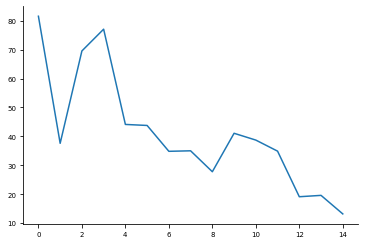

In [ ]:

def get_ttc_rehearsals(logs, rehearsal_no):
    rehearsal_data=[]
    for log in logs:
        tstamps = log.switch_trialxxbatch + [log.total_batches]

        counts = np.zeros(15)
        times_seen =[]
        ttcs = []
        for ti, id in enumerate(log.switch_task_id):
            times_seen.append(counts[id])
            ttcs.append(tstamps[ti+1]- tstamps[ti])
            counts[id] +=1
        rehearsal_data.append(np.array(ttcs)[np.array(times_seen)==rehearsal_no])
    return(np.stack(rehearsal_data))
rd = get_ttc_rehearsals(logs, 1)
plt.plot( rd.mean(0))


Ok, now how much do you have to rehearse as a measures of continual learning. 
Gather rehearsals 0 through 15 with task ids and ttc

So I have 15 rehearsals!
Each has an increasing num of tasks. 
for task id, get all the learning trials
take the first one for analsi, butalso need to know the order....
Some compiling by order, 
and some compiling by task. 
